In [1]:
#!apt-get install git

In [2]:
#!pip install opencv-python

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import cv2
import os
import shutil
import imghdr
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.utils import to_categorical


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
training_path = '/content/drive/MyDrive/projects/Brain_Tumor_Classification/Images_Brain2/Training'
testing_path = '/content/drive/MyDrive/projects/Brain_Tumor_Classification/Images_Brain2/Testing'

In [6]:
!nvidia-smi

Thu Jan  4 14:41:43 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [7]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [8]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

We can see from the above output that Tensorflow is using the NVIDIA Tesla T4 GPU.

In [9]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [10]:
for image_class in os.listdir(training_path):
  print(image_class)


glioma_tumor
meningioma_tumor
pituitary_tumor


In [11]:
class_names = os.listdir(training_path)
class_names

['glioma_tumor', 'meningioma_tumor', 'pituitary_tumor']

In [12]:
os.listdir(os.path.join(training_path,'pituitary_tumor'))[0:5]

['p (130).jpg', 'p (42).jpg', 'p (457).jpg', 'p (167).jpg', 'p (468).jpg']

In [13]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [14]:
img = cv2.imread(os.path.join(training_path, 'pituitary_tumor', 'p (503).jpg'))

In [15]:
img.shape # We can see the image is a 512x512 with a depth of 3

(512, 512, 3)

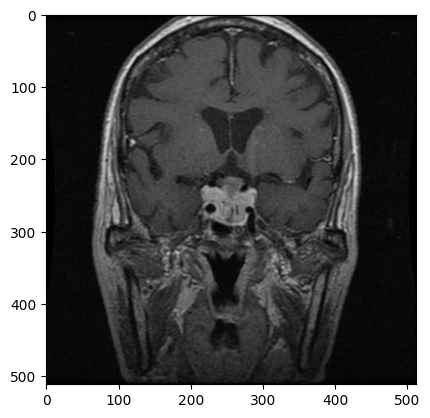

In [16]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB ))
plt.show()

In [17]:
# for image_class in os.listdir(training_path):
#   for image in os.listdir(os.path.join(training_path, image_class)):
#     image_path = os.path.join(training_path, image_class, image)
#     try:
#         img = cv2.imread(image_path)
#         tip = imghdr.what(image_path)
#         if tip not in image_exts:
#             print('Image not in ext list {}'.format(image_path))
#             os.remove(image_path)
#     except Exception as e:
#         print('Issue with image {}'.format(image_path))
#         # os.remove(image_path)

In [18]:
# for image_class in os.listdir(testing_path):
#   for image in os.listdir(os.path.join(testing_path, image_class)):
#     image_path = os.path.join(testing_path, image_class, image)
#     try:
#         img = cv2.imread(image_path)
#         tip = imghdr.what(image_path)
#         if tip not in image_exts:
#             print('Image not in ext list {}'.format(image_path))
#             os.remove(image_path)
#     except Exception as e:
#         print('Issue with image {}'.format(image_path))
#         # os.remove(image_path)

# Loading data

Thr datset was already split into testing and training data so we do not need to define these later

In [94]:
# Load the training dataset
Training_data = tf.keras.utils.image_dataset_from_directory(
    training_path,
    labels='inferred',  # Automatically infer labels from the directory structure
    image_size=(256, 256),
    batch_size=32,
    validation_split=0.2,
    subset='training',
    seed=42
)

# Load the validation dataset
Validation_data = tf.keras.utils.image_dataset_from_directory(
    training_path,
    labels='inferred',
    image_size=(256, 256),
    batch_size=32,
    validation_split=0.2,
    subset='validation',
    seed=42
)

# Load the testing dataset
Testing_data = tf.keras.utils.image_dataset_from_directory(
    testing_path,
    labels='inferred',
    image_size=(256, 256),
    batch_size=32,
)

Found 2475 files belonging to 3 classes.
Using 1980 files for training.
Found 2475 files belonging to 3 classes.
Using 495 files for validation.
Found 289 files belonging to 3 classes.


In [95]:
Training_iterator = Training_data.as_numpy_iterator()
Testing_iterator = Testing_data.as_numpy_iterator()


In [96]:
Training_iterator

In [97]:
batch_training = Training_iterator.next()
# batch_testing = Testing_iterator.next()

In [98]:
len(batch_training)

2

len of 2 as the image is 1 dimension and the label is the  other

In [99]:
batch_training[0].shape

(32, 256, 256, 3)

In [100]:
batch_training[1]

array([2, 2, 1, 1, 0, 0, 1, 2, 2, 0, 2, 2, 0, 1, 0, 0, 1, 2, 1, 2, 0, 2,
       2, 1, 2, 2, 1, 1, 1, 0, 2, 1], dtype=int32)

In [101]:
# Inspect class names
class_names = Training_data.class_names
print("Class Names:", class_names)

Class Names: ['glioma_tumor', 'meningioma_tumor', 'pituitary_tumor']


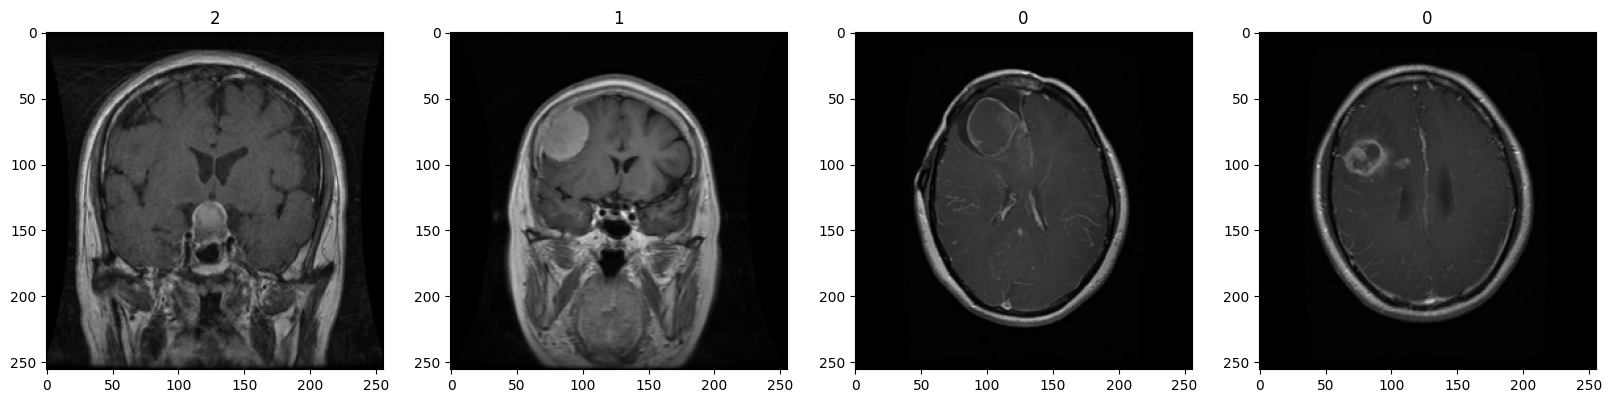

In [102]:
fig, ax = plt.subplots(ncols = 4, figsize = (20,20))
for idx, img_index in enumerate([1,13,14,15]):
    ax[idx].imshow(batch_training[0][img_index].astype(int))
    ax[idx].title.set_text(batch_training[1][img_index])


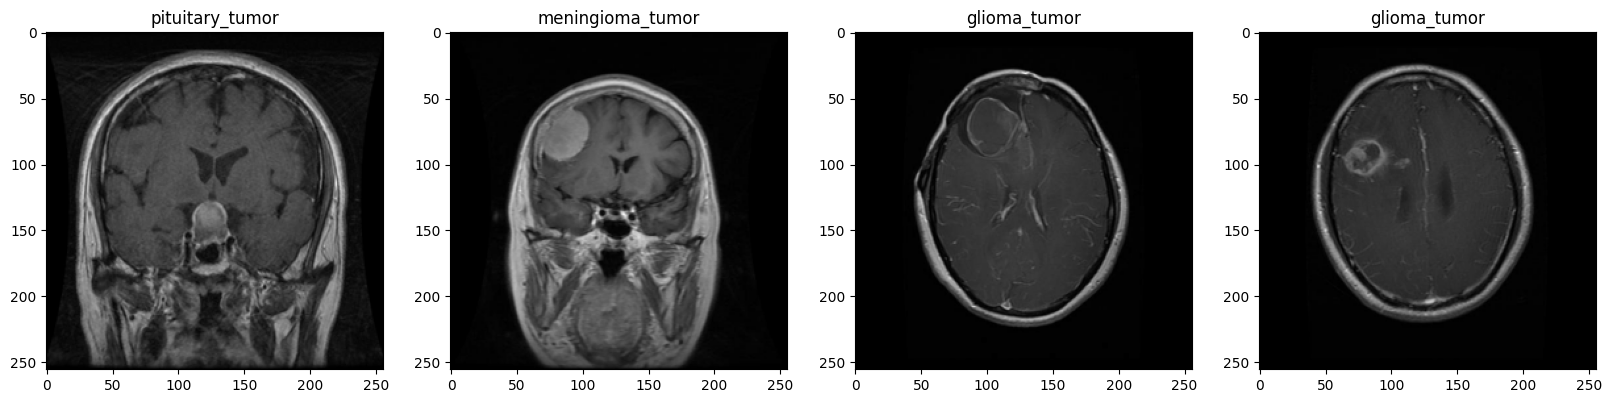

In [103]:

fig, ax = plt.subplots(ncols = 4, figsize = (20,20))
for idx, img_index in enumerate([1,13,14,15]):
    ax[idx].imshow(batch_training[0][img_index].astype(int))
    #ax[idx].title.set_text(batch_training[1][img_index])
    ax[idx].title.set_text(class_names[batch_training[1][img_index]])


#### Labels
-   0 : Glioma Tumor
-   1 : Meningioma Tumor
-   2 : Pituitary Tumor


# Preprocessing Data

In [104]:
def augment_image(x, y):

     # Random left-right flip
    # x = tf.image.random_flip_left_right(x)
    # # Random up-down flip
    # x = tf.image.random_flip_up_down(x)

     # Random rotation (90-degree increments)
    num_rotations = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    x = tf.image.rot90(x, k=num_rotations)

    # # Random zoom (zooming in or out)
    # zoom_factor = tf.random.uniform(shape=[], minval=0.8, maxval=1.2)
    # crop_size = tf.cast(tf.cast(tf.shape(x)[0:2], dtype=tf.float32) * zoom_factor, dtype=tf.int32)
    # x = tf.image.central_crop(x, central_fraction=zoom_factor)
    # x = tf.image.resize(x, crop_size)
    # )
    # Add more augmentation functions as needed
    return x, y

In [105]:
num_classes = 3  # Adjust based on your number of classes

# Load the training dataset
Training_data = Training_data.map(augment_image)
Training_data = Training_data.map(lambda x, y: (x / 255.0, tf.one_hot(y, num_classes)))


# Load the validation dataset
Validation_data = Validation_data.map(augment_image)
Validation_data = Validation_data.map(lambda x, y: (x / 255.0, tf.one_hot(y, num_classes)))

# Load the testing dataset
Validation_data = Validation_data.map(augment_image)
Testing_data = Testing_data.map(lambda x, y: (x / 255.0, tf.one_hot(y, num_classes)))

# X is Images
# Y is Labels


In [106]:
#Training_data

#### Labels
-   [1,0,0,0] : Glioma Tumor
-   [0,1,0,0]  : Meningioma Tumor
-   [0,0,1,0]  : No Tumor
-   [0,0,0,1]  : Pituitary Tumor


# Deep Model

In [107]:
# google how to use dropout


In [213]:
model = Sequential()

# First have an input layer, going to have 16 filters, filter is a 3x3, stride of 1
# Relu activation turns negative values to 0, and preserves positive values
model.add(Conv2D(32, (3,3), 1, activation = 'relu', input_shape = (256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(64, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Flatten()) # condense values

# Fully connected layers
model.add(Dense(128, activation = 'relu', kernel_regularizer=l2(0.002)))
model.add(Dropout(rate =0.1))

model.add(Dense(16, activation = 'relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(rate=0.1))

model.add(Dense(64, activation = 'relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(rate=0.1))


# Final layer that gives a single output and represets the label
model.add(Dense(3, activation = 'softmax'))

In [214]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [215]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_33 (MaxPooli  (None, 127, 127, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_34 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_34 (MaxPooli  (None, 62, 62, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_35 (Conv2D)          (None, 60, 60, 32)        18464     
                                                                 
 max_pooling2d_35 (MaxPooli  (None, 30, 30, 32)      

#### Training

In [216]:
logdir = '/content/drive/MyDrive/projects/Brain_Tumor_Classification/logs'

In [217]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

early_stopping = EarlyStopping(monitor='val_loss', patience=4)

In [218]:
hist = model.fit(Training_data, epochs = 15, validation_data = Validation_data, callbacks = [tensorboard_callback, early_stopping])

Epoch 1/15
62/62 [==============================] - 13s 162ms/step - loss: 1.2030 - accuracy: 0.4960 - val_loss: 0.9876 - val_accuracy: 0.5677
Epoch 2/15
62/62 [==============================] - 11s 177ms/step - loss: 1.0003 - accuracy: 0.5652 - val_loss: 0.9529 - val_accuracy: 0.6000
Epoch 3/15
62/62 [==============================] - 10s 148ms/step - loss: 0.9309 - accuracy: 0.5874 - val_loss: 0.9026 - val_accuracy: 0.6444
Epoch 4/15
62/62 [==============================] - 12s 189ms/step - loss: 0.8998 - accuracy: 0.5975 - val_loss: 0.8843 - val_accuracy: 0.5939
Epoch 5/15
62/62 [==============================] - 11s 175ms/step - loss: 0.8671 - accuracy: 0.6121 - val_loss: 0.8242 - val_accuracy: 0.6808
Epoch 6/15
62/62 [==============================] - 12s 173ms/step - loss: 0.8238 - accuracy: 0.6207 - val_loss: 0.7799 - val_accuracy: 0.6566
Epoch 7/15
62/62 [==============================] - 12s 192ms/step - loss: 0.7892 - accuracy: 0.6652 - val_loss: 0.7455 - val_accuracy: 0.7394

In [219]:
#tf.debugging.disable_traceback_filtering()

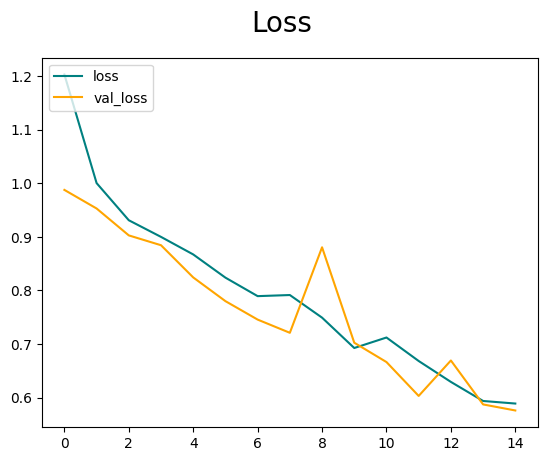

In [220]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

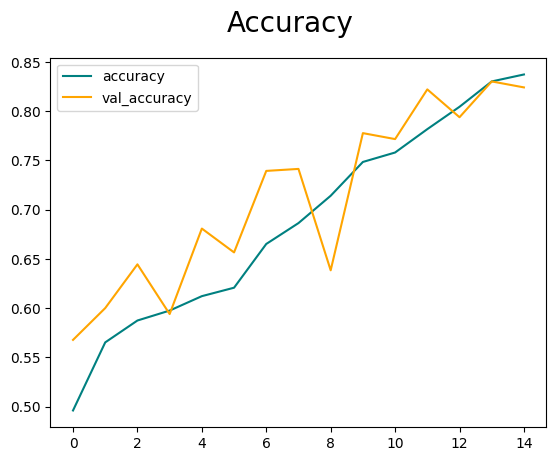

In [221]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [222]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [223]:
labels_testing = []
X_test =[]

for batch in Testing_data.as_numpy_iterator():
    x_test, y_test = batch
    y_test = [np.where(row == 1)[0][0].tolist() for row in y_test]

    labels_testing.extend(y_test)
    X_test.extend(x_test)

labels_testing = np.array(labels_testing)
X_test = np.array(X_test)

In [224]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [225]:
y_ = labels_testing # Our true y values
yhat_ =[] # Empty list for predicted variables
yhat = model.predict(X_test)
yhat_binary = np.argmax(yhat, axis=1)

yhat_.append(yhat_binary)

pre.update_state(y_, yhat_binary)
re.update_state(y_, yhat_binary)
acc.update_state(y_, yhat_binary)

10/10 [==============================] - 0s 26ms/step


<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=289.0>

In [226]:
print(f'Precision: {pre.result().numpy()}')
print(f'Recall: {re.result().numpy()}')
print(f'Accuracy: {acc.result().numpy()}')

Precision: 0.7007874250411987
Recall: 0.9417989253997803
Accuracy: 0.45328718423843384


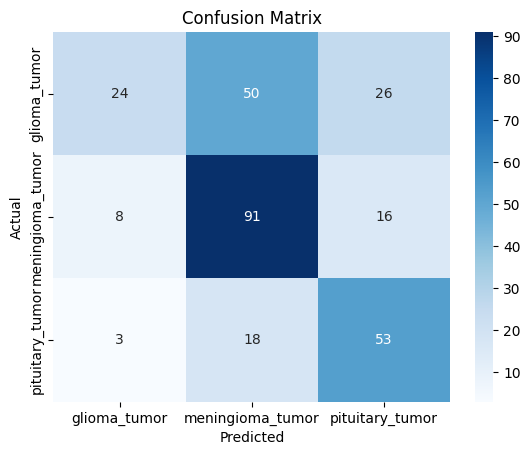

In [227]:
from sklearn.metrics import confusion_matrix
conf = confusion_matrix(y_, yhat_binary)

sns.heatmap(conf, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()